# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm
import os
import glob
from pathlib import Path
import shutil
import zipfile

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, balanced_accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D, Bidirectional, Permute, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import models
from keras import layers
import tensorflow as tf
from keras.utils import plot_model
import keras
from tensorflow.keras.models import load_model

## **Data Preparation**

### **Data Loading**

In [ ]:
import kagglehub

# Setting path ke dataset di kaggle
path = kagglehub.dataset_download("charuchaudhry/plantvillage-tomato-leaf-dataset")

print("Path to dataset files:", path)

# Direktori sumber dataset di Kaggle, menunjuk langsung ke subfolder 'plantvillage'
source_dir = os.path.join(path, "plantvillage/plantvillage")

# Direktori tujuan untuk menyalin dataset
destination_dir = "/content/dataset"

# Salin isi dari source_dir ke destination_dir
shutil.copytree(source_dir, destination_dir)

print(f"Dataset disalin dari {source_dir} ke {destination_dir}")

Path to dataset files: /kaggle/input/plantvillage-tomato-leaf-dataset
Dataset disalin dari /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage ke /content/dataset


In [ ]:
# Definisikan data path
mainPath = "/content"

# Gabungkan dengan path dataset
dataPath = mainPath + "/dataset"

In [ ]:
# Fungsi untuk menghitung jumlah gambar dalam folder
def count_images(folder_path):
    count_all_data = []
    for subdir in os.listdir(folder_path):
      subdir_path = os.path.join(folder_path, subdir)

      # Hanya memproses folder direktori (bukan file)
      if os.path.isdir(subdir_path):
          image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
          num_images = len(image_files)
          count_all_data.append(num_images)
          print(f"{subdir}: {num_images}")

    return print(f"Total File {folder_path}: {sum(count_all_data)}\n")

In [ ]:
count_images(dataPath)

Tomato___Bacterial_spot: 1702
Tomato___healthy: 1273
Tomato___Late_blight: 1527
Tomato___Early_blight: 800
Tomato___Septoria_leaf_spot: 1417
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286
Tomato___Leaf_Mold: 761
Tomato___Tomato_mosaic_virus: 299
Tomato___Spider_mites Two-spotted_spider_mite: 1341
Tomato___Target_Spot: 1123
Total File /content/dataset: 14529



In [ ]:
# Dapatkan daftar semua item (folder dan file) di direktori dataset
items = os.listdir(dataPath)

# Iterasi melalui setiap item
for item in items:
    old_path = os.path.join(dataPath, item)
    # Periksa apakah item tersebut adalah direktori
    if os.path.isdir(old_path):
        # Periksa jika nama folder diawali dengan "Tomato__"
        if item.startswith("Tomato___"):
            # Buat nama folder baru dengan menghapus "Tomato__"
            new_item_name = item.replace("Tomato___", "")
            new_path = os.path.join(dataPath, new_item_name)

            # Ganti nama folder
            os.rename(old_path, new_path)
            print(f"Ganti nama '{item}' menjadi '{new_item_name}'")

print("Proses penggantian nama folder selesai.")

Ganti nama 'Tomato___Bacterial_spot' menjadi 'Bacterial_spot'
Ganti nama 'Tomato___healthy' menjadi 'healthy'
Ganti nama 'Tomato___Late_blight' menjadi 'Late_blight'
Ganti nama 'Tomato___Early_blight' menjadi 'Early_blight'
Ganti nama 'Tomato___Septoria_leaf_spot' menjadi 'Septoria_leaf_spot'
Ganti nama 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' menjadi 'Tomato_Yellow_Leaf_Curl_Virus'
Ganti nama 'Tomato___Leaf_Mold' menjadi 'Leaf_Mold'
Ganti nama 'Tomato___Tomato_mosaic_virus' menjadi 'Tomato_mosaic_virus'
Ganti nama 'Tomato___Spider_mites Two-spotted_spider_mite' menjadi 'Spider_mites Two-spotted_spider_mite'
Ganti nama 'Tomato___Target_Spot' menjadi 'Target_Spot'
Proses penggantian nama folder selesai.


In [ ]:
# Melakukan downsampling untuk data dengan kategori 'Tomato_Yellow_Leaf_Curl_Virus'
Tomato_Yellow_Leaf_Curl_Virus_path = os.path.join(dataPath, 'Tomato_Yellow_Leaf_Curl_Virus')
if os.path.exists(Tomato_Yellow_Leaf_Curl_Virus_path):
    Tomato_Yellow_Leaf_Curl_Virus_files = os.listdir(Tomato_Yellow_Leaf_Curl_Virus_path)

    # Ambil 1300 file secara acak jika jumlahnya lebih besar
    if len(Tomato_Yellow_Leaf_Curl_Virus_files) > 1300:
        sampled_files = random.sample(Tomato_Yellow_Leaf_Curl_Virus_files, 1300)

        # Identifikasi file yang akan dihapus (file yang tidak termasuk dalam sampel)
        files_to_delete = list(set(Tomato_Yellow_Leaf_Curl_Virus_files) - set(sampled_files))

        # Hapus file yang tidak diinginkan dari direktori
        for file_to_delete in files_to_delete:
            file_path = os.path.join(Tomato_Yellow_Leaf_Curl_Virus_path, file_to_delete)
            os.remove(file_path)

        print(f"Downsampling untuk 'Tomato_Yellow_Leaf_Curl_Virus' berhasil dilakukan. Jumlah files: {len(os.listdir(Tomato_Yellow_Leaf_Curl_Virus_path))}")
    else:
        print(f"Downsampling tidak diperlukan untuk 'Tomato_Yellow_Leaf_Curl_Virus'. Jumlah files sudah {len(Tomato_Yellow_Leaf_Curl_Virus_files)}")

Downsampling untuk 'Tomato_Yellow_Leaf_Curl_Virus' berhasil dilakukan. Jumlah files: 1300


In [ ]:
# Tentukan path ke folder yang ingin dihapus
delete_Mosaic_Virus = os.path.join(dataPath, 'Tomato_mosaic_virus')

# Periksa apakah folder ada sebelum dihapus
if os.path.exists(delete_Mosaic_Virus):
    shutil.rmtree(delete_Mosaic_Virus)
    print(f"Folder '{delete_Mosaic_Virus}' berhasil dihapus.")
else:
    print(f"Folder '{delete_Mosaic_Virus}' tidak ditemukan.")

Folder '/content/dataset/Tomato_mosaic_virus' berhasil dihapus.


In [ ]:
# Jumlah Dataset Setelah Downsampling
count_images(dataPath)

Spider_mites Two-spotted_spider_mite: 1341
Tomato_Yellow_Leaf_Curl_Virus: 1300
Leaf_Mold: 761
Septoria_leaf_spot: 1417
Early_blight: 800
Bacterial_spot: 1702
healthy: 1273
Late_blight: 1527
Target_Spot: 1123
Total File /content/dataset: 11244



In [ ]:
# Mengambil direktori untuk seluruh data
dist = [i for i in glob.glob(dataPath + "//*//*")]
np.random.shuffle(dist)
labels = [os.path.dirname(i).split("/")[-1] for i in dist]
data = zip(dist, labels)
all_data = pd.DataFrame(data, columns = ["Image", "Label"])
all_data

Image  \
0      /content/dataset/Tomato_Yellow_Leaf_Curl_Virus...   
1      /content/dataset/Early_blight/3726eff6-547d-41...   
2      /content/dataset/Tomato_Yellow_Leaf_Curl_Virus...   
3      /content/dataset/Spider_mites Two-spotted_spid...   
4      /content/dataset/Late_blight/94b06669-5f80-4a7...   
...                                                  ...   
11239  /content/dataset/Septoria_leaf_spot/fbd92c9a-4...   
11240  /content/dataset/Tomato_Yellow_Leaf_Curl_Virus...   
11241  /content/dataset/healthy/2aeb668a-251a-4f68-b5...   
11242  /content/dataset/Spider_mites Two-spotted_spid...   
11243  /content/dataset/Target_Spot/d85a58df-b7e9-455...   

                                      Label  
0             Tomato_Yellow_Leaf_Curl_Virus  
1                              Early_blight  
2             Tomato_Yellow_Leaf_Curl_Virus  
3      Spider_mites Two-spotted_spider_mite  
4                               Late_blight  
...                                     ...  
11239                    Septoria_leaf_spot  
11240         Tomato_Yellow_Leaf_Curl_Virus  
11241                               healthy  
11242  Spider_mites Two-spotted_spider_mite  
11243                           Target_Spot  

[11244 rows x 2 columns]

<ipython-input-12-c543a3c5d9e0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=all_data["Label"], palette="viridis_r")


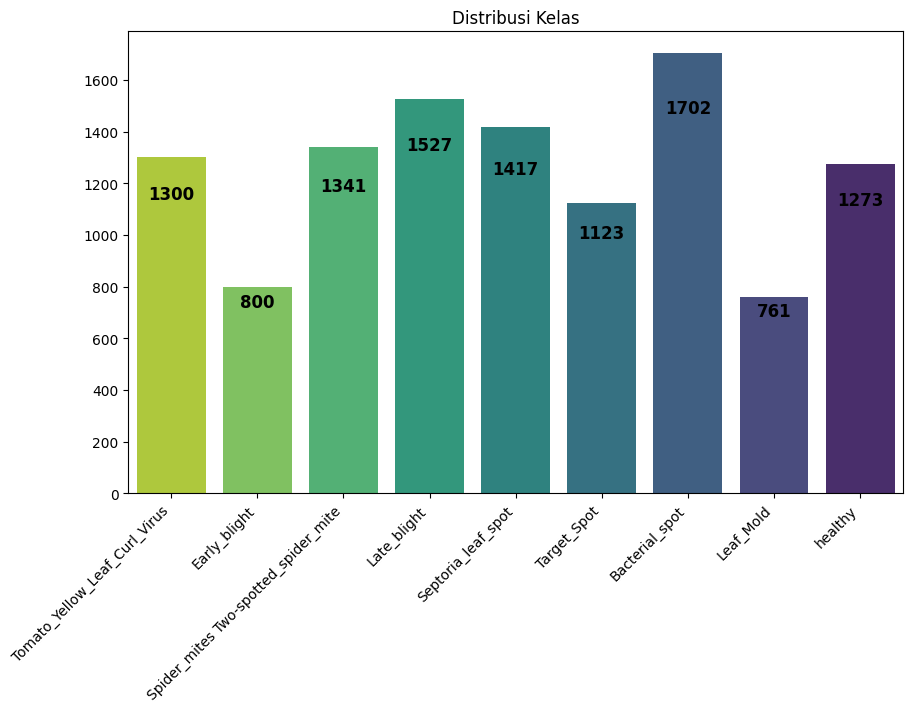

In [ ]:
# Menghitung Jumlah Kelas Setelah Downsampling
label_counts = all_data["Label"].value_counts()

# Membuat CountPlot untuk menghitung kelas
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=all_data["Label"], palette="viridis_r")

# Menambahkan angka pada setiap bar untuk memperlihatkan jumlah setiap kelas
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()/1.2),
                ha = 'center', va = 'baseline',
                xytext = (0, 10), textcoords = 'offset points', fontsize=12, fontweight='bold', color='black')

# Menambahkan judul dan menampilkan CountPlot
plt.title('Distribusi Kelas')
plt.xticks(rotation = 45, ha="right")
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [ ]:
# Membuat fungsi untuk melihat resolusi gambar
def print_images_resolution(directory, max_images_per_class=10):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sampled_files = image_files[:max_images_per_class]  # Mengambil maksimal gambar per kelas
        num_images = len(sampled_files)

        print(f"{subdir}: {num_images}")
        total_images += num_images

        # Melakukan reset untuk setiap iterasi kelas
        unique_sizes = set()
        for img_file in sampled_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

In [ ]:
# Menjalankan fungsi print_image_resolution untuk menampilkan 20 gambar dari tiap kelasnya
print_images_resolution(dataPath, max_images_per_class=5)

Spider_mites Two-spotted_spider_mite: 5
- (256, 256)
---------------
Tomato_Yellow_Leaf_Curl_Virus: 5
- (256, 256)
---------------
Leaf_Mold: 5
- (256, 256)
---------------
Septoria_leaf_spot: 5
- (256, 256)
---------------
Early_blight: 5
- (256, 256)
---------------
Bacterial_spot: 5
- (256, 256)
---------------
healthy: 5
- (256, 256)
---------------
Late_blight: 5
- (256, 256)
---------------
Target_Spot: 5
- (256, 256)
---------------


In [ ]:
# Mendefinisikan fungsi untuk menampilkan sample data dari tiap kelasnya
def one_image_per_class(directory):
    classes = [cls for cls in os.listdir(directory) if os.path.isdir(os.path.join(directory, cls))]
    num_classes = len(classes)
    cols = 3
    rows = (num_classes + cols - 1) // cols

    plt.figure(figsize=(20, rows * 6))
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            continue
        img_file = random.choice(image_files)
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(cls, fontsize=25)
    plt.tight_layout()
    plt.show()

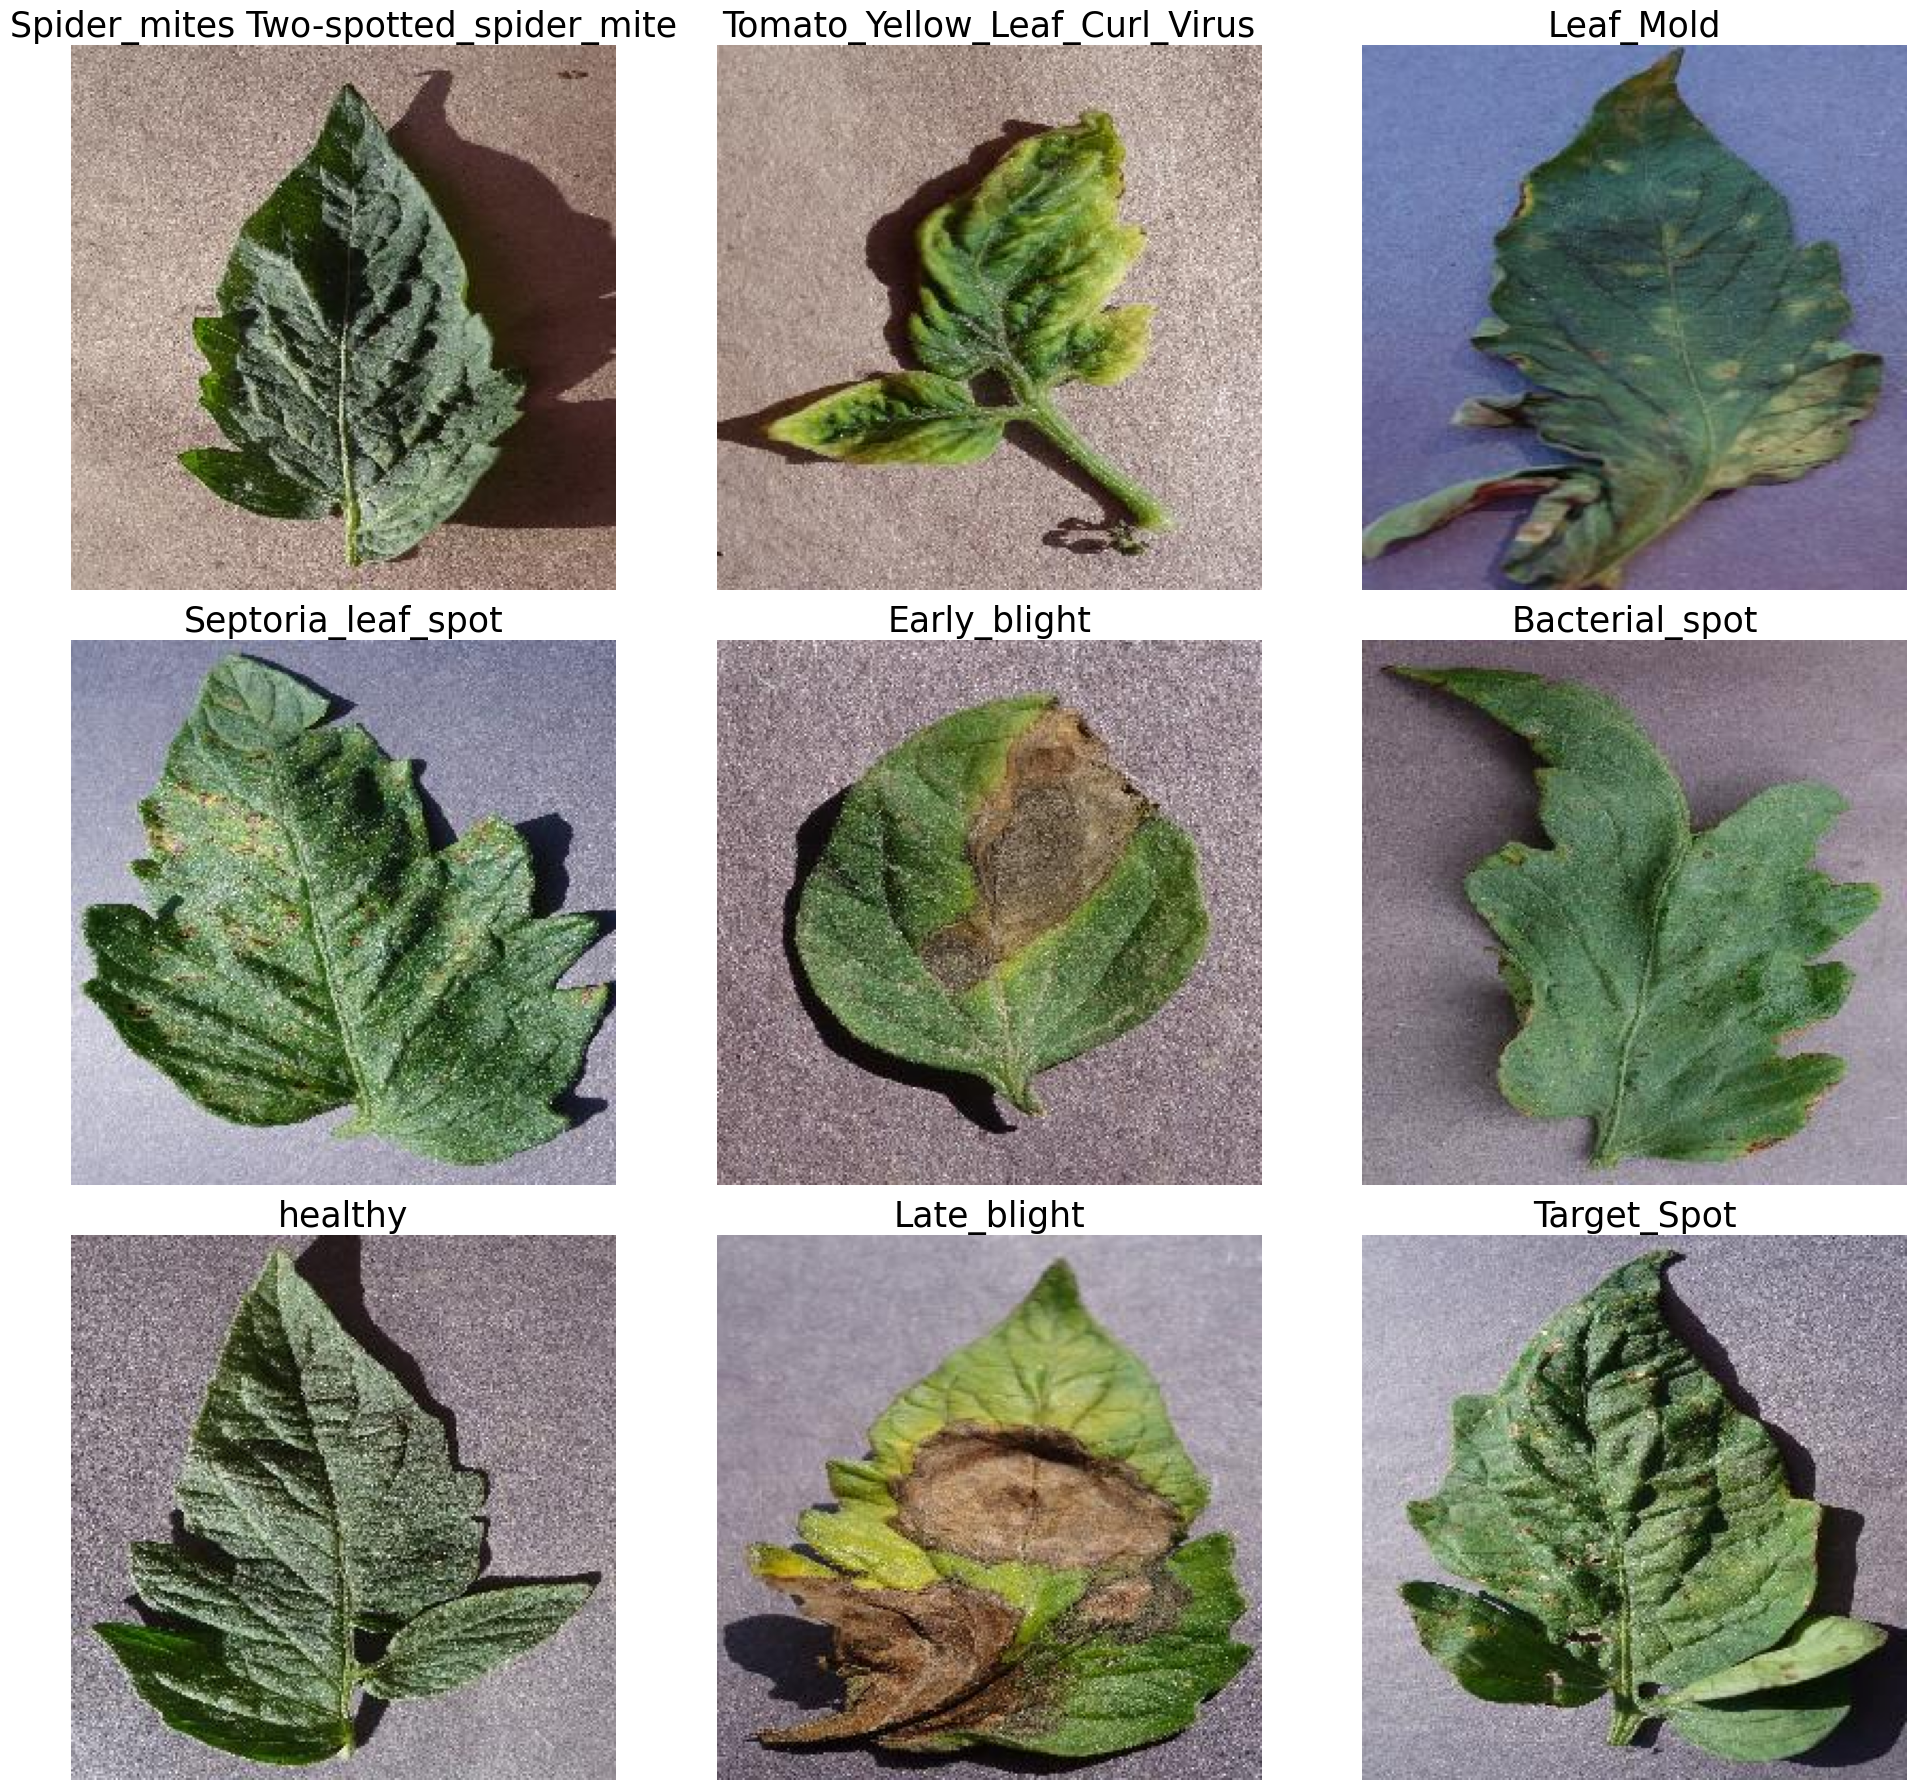

In [ ]:
# Menjalankan fungsi untuk menampilkan sample data dari tiap kelasnya
one_image_per_class(dataPath)

In [ ]:
# Menentukan direktori untuk train, val, dan test
train_dir = mainPath + "/input/train"
val_dir = mainPath + "/input/val"
test_dir = mainPath + "/input/test"

# Menentukan ukuran Batch dan Target
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

In [ ]:
# Membuat dictionary untuk setiap label kelas
classes = os.listdir(dataPath)
class_indices = {name: index for index, name in enumerate(classes)}
class_indices

{'Spider_mites Two-spotted_spider_mite': 0,
 'Tomato_Yellow_Leaf_Curl_Virus': 1,
 'Leaf_Mold': 2,
 'Septoria_leaf_spot': 3,
 'Early_blight': 4,
 'Bacterial_spot': 5,
 'healthy': 6,
 'Late_blight': 7,
 'Target_Spot': 8}

In [ ]:
# Membuat subdirektori berdasarkan kelas untuk folder train, val, dan test
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
    for cls in classes:
        os.makedirs(os.path.join(directory, cls), exist_ok=True)

In [ ]:
# Menentukan seed untuk reprodusibilitas
random.seed(42)

# Mendefinisikan fungsi untuk membagi dengan stratifikasi jika memungkinkan
def split(images, test_size, stratify_labels=None):
    if stratify_labels is not None and len(set(stratify_labels)) > 1:
      # Menjalankan stratifikasi jika memiliki stratify_labels dan kategori > 1
        return train_test_split(images, test_size=test_size, stratify=stratify_labels, random_state=42)
    else:
      # Menjalankan shuffle ketika stratifikasi tidak bisa dilakukan
        return train_test_split(images, test_size=test_size, random_state=42, shuffle=True)

In [ ]:
# Memeriksa jumlah gambar dalam kelas sebelum melakukan split
for cls in classes:
    class_path = os.path.join(dataPath, cls)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if len(images) < 2:
          # Melewati kelas yang jumlah gambarnya kurang dari 2
            print(f"'{cls}' Invalid, karena hanya {len(images)} gambar yang akan dieksekusi")
            continue

        # Membuat label dummy untuk melakukan stratifikasi saat membagi data (label berdasarkan nama file)
        labels = [cls] * len(images)

        # Melakukan splitting data menjadi training, validation dan test
        train_images, temp_images = split(images, test_size=0.40, stratify_labels=labels)
        val_images, test_images = split(temp_images, test_size=0.30, stratify_labels=[cls] * len(temp_images))

        # Memastikan direktori untuk menyimpan data training, validation, dan testing telah dibuat sebelum proses pemindahan
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        # Mendefinisikan fungsi untuk memindahkan data dan memastikan direktori tujuan masih belum terisi
        def move_images(image_list, source, destination):
            if len(os.listdir(destination)) == 0:
                for image in image_list:
                    shutil.copy(os.path.join(source, image), os.path.join(destination, image))
                print(f"Berhasil memindahkan ke '{destination}' sebanyak {len(image_list)} data")
            else:
                print(f"Tidak bisa memindahkan, karena data sudah tersedia di '{destination}'.")

        # Menjalankan fungsi untuk memindahkan data ke masing-masing direktori (training, validation, test)
        move_images(train_images, class_path, os.path.join(train_dir, cls))
        move_images(val_images, class_path, os.path.join(val_dir, cls))
        move_images(test_images, class_path, os.path.join(test_dir, cls))

        print("_" * 60)

Berhasil memindahkan ke '/content/input/train/Spider_mites Two-spotted_spider_mite' sebanyak 804 data
Berhasil memindahkan ke '/content/input/val/Spider_mites Two-spotted_spider_mite' sebanyak 375 data
Berhasil memindahkan ke '/content/input/test/Spider_mites Two-spotted_spider_mite' sebanyak 162 data
____________________________________________________________
Berhasil memindahkan ke '/content/input/train/Tomato_Yellow_Leaf_Curl_Virus' sebanyak 780 data
Berhasil memindahkan ke '/content/input/val/Tomato_Yellow_Leaf_Curl_Virus' sebanyak 364 data
Berhasil memindahkan ke '/content/input/test/Tomato_Yellow_Leaf_Curl_Virus' sebanyak 156 data
____________________________________________________________
Berhasil memindahkan ke '/content/input/train/Leaf_Mold' sebanyak 456 data
Berhasil memindahkan ke '/content/input/val/Leaf_Mold' sebanyak 213 data
Berhasil memindahkan ke '/content/input/test/Leaf_Mold' sebanyak 92 data
____________________________________________________________
Berhasil me

In [ ]:
# Mendefinisikan fungsi untuk menghitung sample gambar setiap sub directory
def count_samples(directory):
    total_images = 0
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):  # Pastikan hanya folder yang dihitung
            total_images += len(os.listdir(subdir_path))  # Menghitung gambar di setiap subfolder
    return total_images

# Menjalankan fungsi untuk menghitung jumlah sample dari train, validation dan test
train_samples = count_samples(train_dir)
validation_samples = count_samples(val_dir)
test_samples = count_samples(test_dir)

# Menampilkan jumlah sample train, validation dan test
print(f"Data Training   : {train_samples}")
print(f"Data Validation : {validation_samples}")
print(f"Data Test       : {test_samples}\n")
print(f"Jumlah total keseluruhan data: {train_samples + validation_samples + test_samples}")
print(f"Jumlah kelas penyakit tomat: {len(classes)}")

Data Training   : 6743
Data Validation : 3147
Data Test       : 1354

Jumlah total keseluruhan data: 11244
Jumlah kelas penyakit tomat: 9


Melakukan pengecekan kebocoran data/duplikasi setelah dilakukan splitting dataset

In [ ]:
# Membaca data pada setiap direktori folder train, val, dan test
train_images = set()
val_images = set()
test_images = set()

# Memeriksa data duplication antara train, val, dan test
overlap = train_images & val_images | train_images & test_images | val_images & test_images

if overlap:
    print(f"Terdapat duplikasi data: {overlap}")
else:
    print("Tidak ada duplikasi data.")

Tidak ada duplikasi data.


ImageDataGenerator untuk preprocessing gambar

In [ ]:
# Membuat generator untuk preprocessing gambar dengan ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255, # Melakukan normalisasi skala gambar
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale=1./255)

Preprocessing gambar

In [ ]:
# Melakukan preprocessing data untuk training, validation, dan test menggunakan flow_from_directory untuk membaca data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

Found 6743 images belonging to 9 classes.
Found 3147 images belonging to 9 classes.
Found 1354 images belonging to 9 classes.


In [ ]:
# Mengambil nama kelas dan melakukan mapping ke dalam bentuk indeks
class_names = train_generator.class_indices
class_names_list = list(class_names.keys())  # Membuat list nama kelas
class_indices = {name: index for index, name in enumerate(class_names_list)} # Melakukan mapping kelas ke dalam bentuk indeks

# Menampilkan informasi shape data training, validation, dan test
print("Data Training: ")
print("Classes    : ", train_generator.class_indices)
print("Image shape: ", train_generator.image_shape)
print("_" * 60)

print("Data Validation: ")
print("Classes    : ", validation_generator.class_indices)
print("Image shape: ", validation_generator.image_shape)
print("_" * 60)

print("Data Test: ")
print("Classes    : ", test_generator.class_indices)
print("Image shape: ", test_generator.image_shape)

Data Training: 
Classes    :  {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'healthy': 8}
Image shape:  (224, 224, 3)
____________________________________________________________
Data Validation: 
Classes    :  {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'healthy': 8}
Image shape:  (224, 224, 3)
____________________________________________________________
Data Test: 
Classes    :  {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'healthy': 8}
Image shape:  (224, 224, 3)


## Modelling

Menghitung bobot tiap kelas

In [ ]:
# Mendefinisikan fungsi untuk menghitung bobot kelas untuk menangani ketidakseimbangan kelas dalam dataset
def define_class_weights(train_path):
    files = [i for i in glob.glob(train_path + "//*//*")] # Mengambil semua file gambar dalam direktori
    labels = [os.path.dirname(i).split("/")[-1] for i in files]
    class_labels = sorted(set(labels))
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_labels), y=labels) # Menghitung bobot kelas
    return dict(zip(class_labels, class_weights))

# Menjalankan fungsi menghitung bobot
class_weight_dict = define_class_weights(train_dir)
class_weight_dict

{'Bacterial_spot': np.float64(0.7338121667210795),
 'Early_blight': np.float64(1.5608796296296297),
 'Late_blight': np.float64(0.8179281901989326),
 'Leaf_Mold': np.float64(1.6430311890838207),
 'Septoria_leaf_spot': np.float64(0.881437908496732),
 'Spider_mites Two-spotted_spider_mite': np.float64(0.9318684355997788),
 'Target_Spot': np.float64(1.1132573881459469),
 'Tomato_Yellow_Leaf_Curl_Virus': np.float64(0.9605413105413105),
 'healthy': np.float64(0.981942624144459)}

Mendefinisikan Callback yang akan digunakan

In [ ]:
# Mendefinisikan kelas myCallback untuk menghentikan training jika skor akurasi sudah mencapai angka yang diinginkan
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        if val_accuracy is not None and accuracy is not None:
            if val_accuracy > 0.95 and accuracy > 0.95:  # Menghentikan training jika skor akurasi sudah melebihi 95%
                print("\nTraining diberhentikan, karena skor Akurasi dan Validasi akurasi sudah > 95%.")
                self.model.stop_training = True
            else:
                print("\nMelanjutkan training, skor akurasi belum mencapai > 95%.")
        else:
            print("\nMelanjutkan training.")
callbacks = myCallback()

# Mendefinisikan semua callback EarlyStopping, ReduceLROnPlateu, dan MyCallback
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=2, min_lr=1e-6),
    callbacks  # Kelas MyCallback yang dibuat untuk menghentikan training ketika akurasi sudah > 95%
]

Transfer Learning Base Model dengan model pre-trained MobileNetV2

In [ ]:
# Mendefinisikan base model dari model pre-trained DenseNet121
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet') # Menggunakan bobot 'imagenet'

# Menonaktifkan training base model untuk mempertahankan pengetahuan awal
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Membuat model fine-tuned dengan Sequential
model = models.Sequential(name='MantomaEarlyModel')
model.add(base_model)

# Menambahkan layer Convolutional 2D, Batch Normalization, Pooling Layer pertama
model.add(layers.Conv2D(64, (3,3), padding='same', activation = 'relu')) # Menggunakan fungsi aktivasi 'relu' dan padding
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Menambahkan layer Convolutional 2D, Batch Normalization, Pooling Layer kedua
model.add(layers.Conv2D(32, (3,3), padding='same', activation = 'relu')) # Menggunakan fungsi aktivasi 'relu' dan padding
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Menambahkan layer Flatten, Dense, dan Dropout
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) # Menambahkan lapisan filter dengan fungsi aktivasi 'relu'
model.add(layers.Dropout(0.5)) # Menerapkan Dropout untuk menghindari Overfitting
model.add(layers.Dense(len(class_names), activation='softmax'))  # Menggunakan fungsi aktivasi softmax untuk kasus klasfikasi multikelas

# Menambahkan compile untuk mengevaluasi model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model yang dibuat
model.summary()

Model: "MantomaEarlyModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,016,873 (11.51 MB)

 Trainable params: 758,697 (2.89 MB)

 Non-trainable params: 2,258,176 (8.61 MB)

Melatih model

In [ ]:
history = model.fit(
    train_generator,
    epochs = 40, # Melakukan iterasi training sebanyak 40
    validation_data= validation_generator,
    callbacks=callbacks_list, # Menerapkan callback yang telah didefinisikan
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.4094 - loss: 1.7776
Melanjutkan training, skor akurasi belum mencapai > 95%.
106/106 ━━━━━━━━━━━━━━━━━━━━ 115s 938ms/step - accuracy: 0.4108 - loss: 1.7733 - val_accuracy: 0.7077 - val_loss: 0.8688 - learning_rate: 0.0010
Epoch 2/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.7649 - loss: 0.7410
Melanjutkan training, skor akurasi belum mencapai > 95%.
106/106 ━━━━━━━━━━━━━━━━━━━━ 89s 839ms/step - accuracy: 0.7650 - loss: 0.7406 - val_accuracy: 0.8217 - val_loss: 0.5163 - learning_rate: 0.0010
Epoch 3/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8171 - loss: 0.5819
Melanjutkan training, skor akurasi belum mencapai > 95%.
106/106 ━━━━━━━━━━━━━━━━━━━━ 87s 822ms/step - accuracy: 0.8171 - loss: 0.5817 - val_accuracy: 0.8491 - val_loss: 0.4778 - learning_rate: 0.0010
Epoch 4/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8476 - loss: 0.4851
Melanjutkan training, skor akurasi belum men

In [ ]:
# Melakukan evaluasi model terhadap Dataset Training
score_train, acc_train = model.evaluate(train_generator)
print('Train Accuracy :', acc_train)
print('Train Loss     :', score_train)

106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 776ms/step - accuracy: 0.9388 - loss: 0.1843
Train Accuracy : 0.9393445253372192
Train Loss     : 0.18342678248882294


In [ ]:
# Melakukan evaluasi model terhadap Dataset Validation
score_val, acc_val = model.evaluate(validation_generator)
print('Validation Accuracy  :', acc_val)
print('Validation Loss      :', score_val)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9061 - loss: 0.2964
Validation Accuracy  : 0.8995869159698486
Validation Loss      : 0.3112938106060028


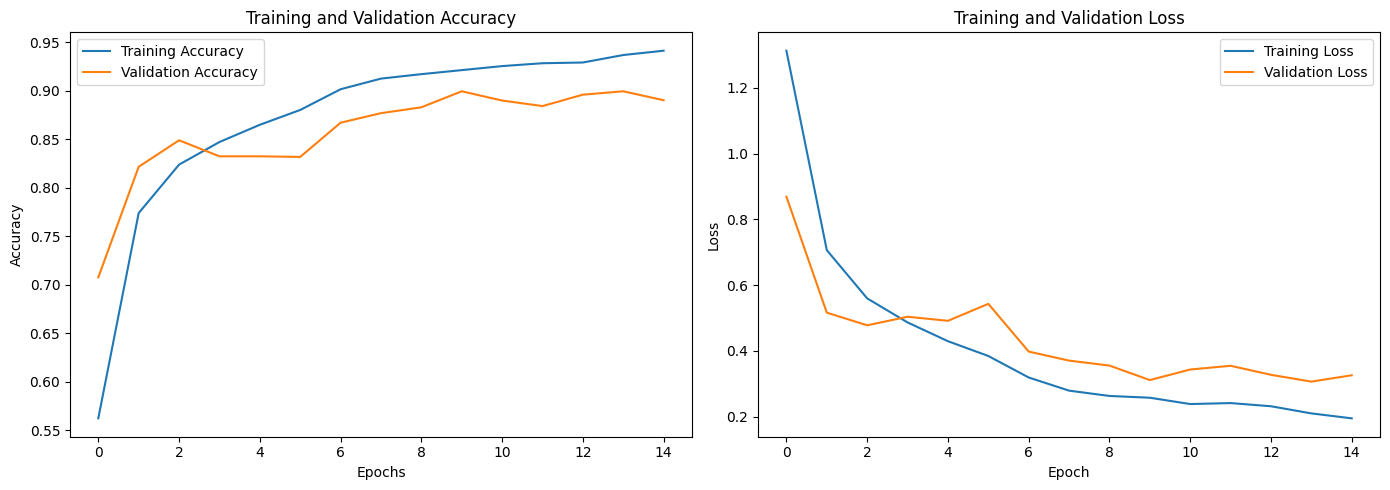

In [ ]:
# Mengambil history dari training model.fit
history_train = history.history

# Membuat plot visualisasi akurasi dari training model
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_train['accuracy'], label='Training Accuracy')
plt.plot(history_train['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Membuat plot visualisasi loss dari training model
plt.subplot(1, 2, 2)
plt.plot(history_train['loss'], label='Training Loss')
plt.plot(history_train['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Menampilkan plot visualisasi akurasi dan loss dari training model
plt.tight_layout()
plt.show()

Evaluasi Model pada Data Test

In [ ]:
# Melakukan evaluasi model terhadap Dataset Test
score_test, acc_test = model.evaluate(test_generator)
print(f'Test Accuracy : {acc_test}')
print(f'Test Loss     : {score_test}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9024 - loss: 0.3169
Test Accuracy : 0.905465304851532
Test Loss     : 0.2870715856552124
